In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# CONSTANTS
tubL, tubW, tubH = 1.25, 0.60, 0.35 # meters
molWaterInM3 = 55493.9 # mol / meter^3
humanCP = 62.97 # J / mol K

In [75]:
# VARIABLES
countL, countW, countH = 5, 5, 5#40, 20, 10#5, 5, 5 #50, 25, 25 # dimensionless
bathStartingTemp = 37.0 # deg celsius
bathThermalDiffusivity = 22e-6 # cast iron thermal diffusivity
dt = 0.1 # seconds

In [76]:
def getWaterDiffusivity(temp):
    lmda = 0.561 + 0.002 * temp + 0.00000962 * (temp ** 2)
    cp = 75.98 - 0.061 * temp + 0.002 * (temp ** 2) - 0.00001755 * (temp ** 3)
    rho = 999.86 + 0.058 * temp - 0.008 * (temp ** 2) + 0.0000397 * (temp ** 3)
    return lmda / (cp * rho)

def getSubsectionVolumeMols():
    return molWaterInM3 * (tubL/countL) * (tubW/countW) * (tubH/countH)

def getNewTempArray():
    return bathStartingTemp*np.ones((countL+1, countW+1, countH+1))

def getTubSafe(tub, l, w, h):
    if l < 0 or l > countL: return bathStartingTemp
    if w < 0 or w > countW: return bathStartingTemp
    if h < 0 or h > countH: return bathStartingTemp
    return tub[l][w][h]

def getPointDiffusivity(tub, l, w, h):
    if l == 0 or l == countL: return bathThermalDiffusivity
    if w == 0 or w == countW: return bathThermalDiffusivity
    if h == 0 or h == countH: return bathThermalDiffusivity
    return getWaterDiffusivity(tub[l][w][h])

def getCellLagrangian(tub, l, w, h):
    distL, distW, distH = tubL/countL, tubW/countW, tubH/countH
    # print(tub[l-1][w][h], tub[l][w][h], tub[l+1][w][h])
    ddL = float(getTubSafe(tub, l+1, w, h) + getTubSafe(tub, l-1, w, h) - 2 * getTubSafe(tub, l, w, h)) / (distL ** 2)
    ddW = float(getTubSafe(tub, l, w+1, h) + getTubSafe(tub, l, w-1, h) - 2 * getTubSafe(tub, l, w, h)) / (distW ** 2)
    ddH = float(getTubSafe(tub, l, w, h+1) + getTubSafe(tub, l, w, h-1) - 2 * getTubSafe(tub, l, w, h)) / (distH ** 2)
    return (ddL, ddW, ddH)
    
def cellStep(tub):
    diffusionL, diffusionW, diffusionH = np.copy(tub), np.copy(tub), np.copy(tub)
    for l in range(0, countL+1):
        for w in range(0, countW+1):
            for h in range(0, countH+1):
                wd = getPointDiffusivity(tub, l, w, h)
                dd = getCellLagrangian(tub, l, w, h)
                mm = getSubsectionVolumeMols()
                diffusionL[l][w][h], diffusionW[l][w][h], diffusionH[l][w][h] = dt*mm*wd*dd[0], dt*mm*wd*dd[1], dt*mm*wd*dd[2]
    tmp = np.add(diffusionL, diffusionW)
    tmp = np.add(tmp, diffusionH)
    #print(tmp)
    return np.add(tub, tmp)
    #print(np.add(tub, tmp))

(-12.048794382179267, 0.6004479069727293, -25.242480588251027)
(9.531256032991905, -9.127811120137608, -11.511668630790885)
(7.203230083599692, -4.831541207295231, -12.776527732285686)
[[[ 37.12550045  37.2137842   37.23946296  37.20811628  37.14482104
    37.07230341]
  [ 37.20720069  37.35799421  37.39566949  37.33448975  37.22577282
    37.11027838]
  [ 37.15746045  37.2682545   37.29411444  37.24763379  37.16712846
    37.08208058]
  [ 37.07710437  37.1293086   37.14114101  37.11923396  37.08113469
    37.04027118]
  [ 37.02815762  37.04667473  37.0508919   37.04327522  37.02975129
    37.01491083]
  [ 37.00807845  37.01338473  37.01466372  37.01257653  37.00872017
    37.00437759]]

 [[ 37.50072922  37.87777028  37.95723172  37.78429283  37.50924303
    37.24099772]
  [ 38.01010488  39.05980125  39.16087751  38.60570689  37.9249012
    37.39791238]
  [ 37.68462505  38.30227213  38.3234866   37.95615467  37.54110709
    37.2464257 ]
  [ 37.27418116  37.47148039  37.46124904  37.325

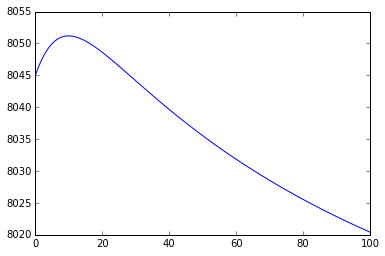

In [77]:
arr = getNewTempArray();
arr[1][1][1] = 90

aList = [np.sum(arr)]

for i in range(0, 100):
    arr = cellStep(arr)
    #print("STEP " + str(i))
    #print(np.sum(arr))
    aList.append(np.sum(arr))
plt.plot(aList)
print(getCellLagrangian(arr, 1, 0, 0))
print(getCellLagrangian(arr, 0, 1, 0))
print(getCellLagrangian(arr, 0, 0, 1))
print(arr)
#print(aList)